# Fair Preprocessing Ranking

In [1]:
import pandas as pd
import os
import ast
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import ColumnTransformer

In [3]:
from findhr.preprocess.mapping import AttachMetadata, DerivedColumn, DetachMetadata
from findhr.preprocess.example_mappings import RelevantExperienceForRole, ExtractMonthDurationJob, MatchOrdinal, ExtractListOfProperty, MatchFeatureAtLeastInList, MatchFeatureSet, MatchBinary

In [4]:
from findhr.fairness.fairness_method_iFair import iFair
from findhr.fairness.fairness_method_gFair import gFair
from findhr.fairness.fairness_method_LFR import LFR
from findhr.fairness.utils.utils import generate_ranking

## **Data**

In [5]:
def create_train_test_split(df, query_col, id_col, sensitive_col, sort_col, pos_th, return_ratio, out_path):

    # create a column to represent the intersectional values
    if len(sensitive_col) > 1:
        sensitive_col_intersectional = "_".join(sensitive_col)
        temp = [""] * len(df)
        for col in sensitive_col:
            temp += df[col].astype(str)
        df[sensitive_col_intersectional] = temp
        sensitive_col = sensitive_col_intersectional
    
    if not os.path.exists(os.path.join(out_path, "train_data.csv")):
        # splitting the dataset into training and testing sets
        train_samples, test_samples = [], []
        for qid, df_query in df.groupby(query_col):
            pos_samples = df_query[df_query[sort_col] >= pos_th]  # Positive samples
            neg_samples = df_query[df_query[sort_col] < pos_th]  # Negative samples
    
            # identify groups with insufficient samples
            group_sizes = pos_samples[sensitive_col].value_counts()
            insufficient_groups = group_sizes[group_sizes < 2].index.tolist()
    
            if insufficient_groups:
                drop_qid.append(qid)
                print(f"QID {qid} does not have enough samples")
                continue  # skip this query group if it has insufficient data
    
            # perform stratified sampling
            stratified_pos_sample = pos_samples.groupby(sensitive_col, group_keys=False).apply(
                lambda x: x.sample(frac=return_ratio, random_state=42))
            stratified_neg_sample = neg_samples.groupby(sensitive_col, group_keys=False).apply(
                lambda x: x.sample(frac=return_ratio, random_state=42))
    
            train_samples.extend(stratified_pos_sample[id_col].values)
            train_samples.extend(stratified_neg_sample[id_col].values)
    
            test_samples.extend(df_query.loc[~df_query[id_col].isin(train_samples), id_col].values)

        df_train = df[df[id_col].isin(train_samples)]
        df_test = df[df[id_col].isin(test_samples)]
           
        df_train.reset_index(drop=True, inplace=True)
        df_test.reset_index(drop=True, inplace=True)
        df_train.to_csv(os.path.join(out_path, "train_data.csv"))
        df_test.to_csv(os.path.join(out_path, "test_data.csv"))
    else:
        df_train = pd.read_csv(os.path.join(out_path, "train_data.csv"))
        df_test = pd.read_csv(os.path.join(out_path, "test_data.csv"))

        for column in df_train.columns:
            try:
              df_train[column] = df_train[column].apply(lambda x: ast.literal_eval(x))
              df_test[column] = df_test[column].apply(lambda x: ast.literal_eval(x))
            except:
              df_train[column] = df_train[column]
              df_test[column] = df_test[column]

    return df_train, df_test


 Run the Input Data Sources notebook to get the input data in the format required with the required metadata information.

In [6]:
%run Example_InputDataSources.ipynb

Metadata information

In [7]:
md_all

{'id_c': 
 	SCHEMA = {'type': 'number'}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'education_background_c': 
 	SCHEMA = {'type': 'array', 'items': {'type': 'object', 'properties': {'institution': {'type': 'string'}, 'end_date': {'type': 'string'}, 'degree': {'type': 'string'}, 'duration': {'type': 'string'}}}}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'professional_experience_c': 
 	SCHEMA = {'type': 'array', 'items': {'type': 'object', 'properties': {'institution': {'type': 'string'}, 'end_date': {'type': 'string'}, 'role': {'type': 'string'}, 'duration': {'type': 'string'}}}}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'skills_c': 
 	SCHEMA = {'type': 'array', 'items': {'type': 'string'}}
 	ATTR_TYPE = object
 	ATTR_USAGE = default
 	KNOWLEDGE_BASE = None,
 'gender_c': 
 	SCHEMA = {'enum': ['Man', 'Woman', 'Any']}
 	ATTR_TYPE = category
 	ATTR_USAGE = sensitive
 	KNOWLEDGE_BASE = None,
 'agg_perceived_f

Input data formatted as a pandas dataframe

In [8]:
df_all.head()

,id_c,education_background_c,professional_experience_c,skills_c,gender_c,agg_perceived_foreign_c,id_j,education_reqs_j,experience_reqs_role_j,experience_reqs_duration_j,skills_j,gender_j,agg_perceived_foreign_j,ranking,shortlisted,score
0,5,[{'institution': 'Complutense University Of Ma...,"[{'institution': 'Stylo Milano', 'start_date':...","[Communications, Social Integration, Microsoft...",Man,No,5,"[Law Bachelor, Degree In Law, Higher Degree In...",[Consultant],12,"[Punctuality, Organization, Accounting, Englis...",Man,No,4,1,0.0
1,6,[{'institution': 'Coronel Rosales Agricultural...,"[{'institution': 'Securitas Direct', 'start_da...","[Refinancing, Economy, Microsoft Excel, Collec...",Man,No,3,[],"[Sales Assistant, Saleswoman, Commercial Advisor]",12,"[English, Spanish, Communications, Communicati...",Man,No,8,1,0.6
2,10,[{'institution': 'Complutense University Of Ma...,"[{'institution': 'Carrefour Express', 'start_d...","[Entrepreneurship, Literacy, Web Design, Adobe...",Woman,No,5,"[Law Bachelor, Degree In Law, Higher Degree In...",[Consultant],12,"[Punctuality, Organization, Accounting, Englis...",Man,No,4,1,0.0
3,11,"[{'institution': 'Les Ribera De Los Molinos', ...","[{'institution': 'Decimas Sl', 'start_date': '...","[Consulting, Sap Crm, Collections, Automation,...",Woman,No,3,[],"[Sales Assistant, Saleswoman, Commercial Advisor]",12,"[English, Spanish, Communications, Communicati...",Man,No,12,0,0.4
4,15,[{'institution': 'Escuela Politcnica Superior ...,"[{'institution': 'Reintegrate', 'start_date': ...","[Microsoft Word, Biofuels, English, Entreprene...",Man,No,3,[],"[Sales Assistant, Saleswoman, Commercial Advisor]",12,"[English, Spanish, Communications, Communicati...",Man,No,5,1,0.7


**Define the preprocessing steps**

In [9]:
# Setting category columns in DataFrame
cat_cols = [k for k, v in md_all.items() if v.attr_type=='category']
df_all[cat_cols] = df_all[cat_cols].astype('category')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1643 entries, 0 to 1642
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id_c                        1643 non-null   int64   
 1   education_background_c      1643 non-null   object  
 2   professional_experience_c   1643 non-null   object  
 3   skills_c                    1643 non-null   object  
 4   gender_c                    1643 non-null   category
 5   agg_perceived_foreign_c     1643 non-null   category
 6   id_j                        1643 non-null   int64   
 7   education_reqs_j            1643 non-null   object  
 8   experience_reqs_role_j      1643 non-null   object  
 9   experience_reqs_duration_j  1643 non-null   int64   
 10  skills_j                    1643 non-null   object  
 11  gender_j                    1643 non-null   category
 12  agg_perceived_foreign_j     1643 non-null   category
 13  ranking           

In [10]:
# Define ids, target feature(s), and predictive features.
id_cols = ['id_c', 'id_j']
target_cols = ['score', 'ranking', 'shortlisted']
pred_cols = df_all.columns.difference(target_cols + id_cols)

In [11]:
# Extract features from the data
maps_derived_1 = {
    (('professional_experience_c', 'experience_reqs_role_j',), ('relevant_exp_role_c',)): RelevantExperienceForRole(),
}

maps_derived_2 = {
        (('relevant_exp_role_c',), ('role_duration_months_c',)): ExtractMonthDurationJob(duration_key='duration_months'),
        (('education_background_c',), ('degree_list_c',)): ExtractListOfProperty(property_key='degree')
}

# Fitness features about the matching between candidate's features and job's requirements.
maps_matching = {
    (('experience_reqs_duration_j', 'role_duration_months_c'), ('fitness_experience',)): MatchOrdinal(),
    (('education_reqs_j', 'education_background_c'), ('fitness_education',)): MatchFeatureAtLeastInList(),
    (('skills_j', 'skills_c'), ('fitness_skills',)): MatchFeatureSet(),
    (('gender_j', 'gender_c'), ('fitness_gender',)): MatchBinary(),
    (('agg_perceived_foreign_j', 'agg_perceived_foreign_c'), ('fitness_foreign',)): MatchBinary()
}

In [12]:
# Define the preprocessor for numeric features: imputing and scaling numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")), # Not needed for the used dataset.
        ("scaler", StandardScaler()) # Not needed for the decision tree, let's keep it for the sake of generality.
    ]
)

In [13]:
# Step 0: define column preprocessing only for the regressor without the fairness intervention in the pipeline
numeric_features_reg = ['fitness_experience', 'fitness_education', 'fitness_skills', 'score']

column_preprocessor_regressor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_reg),
    ]
)

In [14]:
# Step 1: preprocessing the input for the fairness intervention
numeric_features = ['fitness_experience', 'fitness_education', 'fitness_skills', 'score']

column_preprocessor_numerical_pandas = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)

    ],
    remainder='passthrough', # return all columns not only the preprocessed ones
    verbose_feature_names_out=False
).set_output(transform="pandas") # input to the fairness intervention needs to be a pandas dataframe

In [15]:
# Step 2: preprocessing the output of the fairness intervention to be used by the regressor (_fair columns contain the fairer data representation)
numeric_features_out = ['fitness_experience_fair', 'fitness_education_fair', 'fitness_skills_fair', 'score_fair']

# return only columns to be used as training features/labels by the regressor
column_preprocessor_fair_regressor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_out)
    ]
)

In [16]:
# Step 3: define the columns to be pre-processed by the fairness interventions
# this example will run using both sensitive attributes available in the data: 'gender_c' and 'agg_perceived_foreign_c'

query_col_data = 'id_j'
candidate_id = 'id_c'
features_col_data = ['fitness_experience', 'fitness_education', 'fitness_skills']
score_col_data = 'score'
sensitive_col_data = ['gender_c', 'agg_perceived_foreign_c']
intersectional_col_data = "_".join(sensitive_col_data)
columns_display_regressor = [query_col_data, candidate_id, "prediction", intersectional_col_data] + sensitive_col_data + numeric_features
columns_display_fairness = [query_col_data, candidate_id, "prediction", intersectional_col_data] + sensitive_col_data + numeric_features_out

# define the threshold for considering negative candidates (score with less than pos_th is considered as negative candidate)
pos_th = 0.1

# define the output path to save the model and the fairer representation of the candidates
out_path = '../../../data/fairness_output/'
if not os.path.exists(out_path):
    os.makedirs(out_path)

In [17]:
# define the pipeline for data preprocessing with metadata (using findhr package)
pipeline_derived = Pipeline(steps=[
    ("init", AttachMetadata(md_all)),
    ('mapping_1', DerivedColumn(maps_derived_1)),
    ('mapping_2', DerivedColumn(maps_derived_2)),
    ("matching", DerivedColumn(maps_matching)),
    ("end", DetachMetadata())
])

**Create train-test split to train the fairness pre-processing intervention**

In [18]:
# create a stratified train-test split for each job (query_col_data) between negative and positive samples given all sensitive attributes (features_col_data) from the data and save in out_path
df_all_train, df_all_test = create_train_test_split(df_all, query_col_data, candidate_id, sensitive_col_data, score_col_data, pos_th, return_ratio=0.3, out_path=out_path)

## **Train Regressor without Fairness Intervention**

In [19]:
pipeline_regr = Pipeline(
    steps=[
        ('fitness_value', pipeline_derived), 
        ("column_preprocessor", column_preprocessor_regressor), # second phase: preprocessing without metadata (standard scikit-learn)
        ("regressor", DecisionTreeRegressor(max_depth=3)) # model inference
       ]
)

In [20]:
# Fit the pipeline
pipeline_regr.fit(df_all_train, df_all_train.loc[:, 'score'])

Pipeline(steps=[('fitness_value',
                 Pipeline(steps=[('init',
                                  AttachMetadata(metadata_dict={'agg_perceived_foreign_c': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'agg_perceived_foreign_j': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'education_background_c': 
	SC...
	KNOWLEDGE_BASE = None},
                                                                                                                           output_cols=('fitness_skills',))})),
                                 ('end', DetachMetadata())])),
                ('column_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fitness_experience',
                                                   'fitness_education',
                                                   'fitness_skills',
                                                   'score'])])),
                ('regressor', DecisionTreeRegressor(max_depth=3))])

In [21]:
# Get predictions of regressor
df_all_test['prediction'] = pipeline_regr.predict(df_all_test)

In [22]:
columns_display_regressor

['id_j',
 'id_c',
 'prediction',
 'gender_c_agg_perceived_foreign_c',
 'gender_c',
 'agg_perceived_foreign_c',
 'fitness_experience',
 'fitness_education',
 'fitness_skills',
 'score']

In [23]:
# display ranked list
ranking_original = generate_ranking(df_all_test[columns_display_regressor], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank', out_path=os.path.join(out_path, "regressor_ranking.csv"))
ranking_original

,Unnamed: 0,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience,fitness_education,fitness_skills,score,rank
0,0,1,2164,0.777640,ManNo,Man,No,0,0,0.0,0.782609,1
1,1,1,584,0.777640,ManYes,Man,Yes,0,0,0.3,0.713043,2
2,2,1,607,0.777640,ManNo,Man,No,0,0,0.2,0.782609,3
3,3,1,2115,0.777640,ManNo,Man,No,0,0,0.4,0.782609,4
4,4,1,657,0.777640,WomanNo,Woman,No,0,0,0.2,0.782609,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1017,5,1144,0.007809,WomanNo,Woman,No,0,0,0.2,0.000000,94
1018,1018,5,1668,0.007809,ManNo,Man,No,0,0,0.2,0.026756,95
1019,1019,5,68,0.007809,ManNo,Man,No,0,0,0.0,0.000000,96
1020,1020,5,292,0.007809,ManYes,Man,Yes,0,0,0.0,0.024845,97


In [24]:
# display top-10 candidates from the ranked list for an example job title
job_id = 3
df_all_test_job = df_all_test[df_all_test[query_col_data] == job_id]
generate_ranking(df_all_test_job[columns_display_regressor], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank').head(10)

,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience,fitness_education,fitness_skills,score,rank
0,3,148,0.777640,WomanNo,Woman,No,1,1,0.125,0.782609,1
1,3,1571,0.777640,WomanNo,Woman,No,1,1,0.000,0.782609,2
2,3,2047,0.632497,ManYes,Man,Yes,1,1,0.125,0.608696,3
3,3,1472,0.632497,ManNo,Man,No,0,1,0.000,0.608696,4
4,3,1108,0.632497,ManNo,Man,No,1,1,0.000,0.695652,5
5,3,1092,0.632497,ManNo,Man,No,1,1,0.125,0.608696,6
6,3,963,0.632497,ManNo,Man,No,1,1,0.250,0.683230,7
7,3,1542,0.632497,WomanNo,Woman,No,0,1,0.500,0.633540,8
8,3,1749,0.632497,ManNo,Man,No,0,1,0.000,0.652174,9
9,3,1104,0.529795,ManNo,Man,No,1,1,0.125,0.504348,10


## **Applying Fairness Pre-processing Intervention**

**LFR Pipeline**

Apply the LFR fair pre-processing intervention. LFR aims at achieving both group and individual fairness by creating representations that obfuscate information about the protected groups, while also ensuring a good encoding of useful information (which aims at preserving the utility of the ranking).

In [25]:
# Define the optimisation type 
# This example is run using the pairwise optimisation  
# optimisation_type = {"pairwise": "all"} # pairwise comparison between all intersectional groups during the optimisation
# optimisation_type = {"independent": "all"} # the default value, which optimizes for each sensitive attribute independently  
# optimisation_type = {"control": "ManNo"} # compares during the optimisation with the specified control value
optimisation_type = {"extremes": ["ManNo", "WomanYes"]} # compares during the optimisation only the defined values

In [26]:
# define the parameters of the pre-processing fairness intervention model
fair_model = LFR(query_col=query_col_data, feature_cols=features_col_data, score_col=score_col_data, sensitive_col=sensitive_col_data,
                                     optimisation_type=optimisation_type, k=10, A_x=1, A_y=1, A_z=10, model_occ=True, pos_th=pos_th,  out_path=out_path, verbose=True, print_interval=1000)

In [39]:
# if you don't want to use the scikit pipeline tu run the fairness pre-processing interventions you can do the following
fair_model.fit(df_all_train)
df_all_fair_test = fair_model.transform(df_all_test)
df_all_fair_test

,Unnamed: 0.1,fitness_experience_fair,fitness_education_fair,fitness_skills_fair,score_fair,fitness_experience,fitness_education,fitness_skills,score,Unnamed: 0,...,agg_perceived_foreign_j,ranking,shortlisted,gender_c_agg_perceived_foreign_c,relevant_exp_role_c,role_duration_months_c,degree_list_c,fitness_gender,fitness_foreign,gender_c_agg_perceived_foreign_c_coded
0,0,-0.541418,-0.363636,-0.842891,-0.174706,-0.351388,-0.245315,-1.219419,0.138767,0,...,No,22,0,WomanNo,[],0,['Degree In Law'],0,1,3
1,1,-0.555659,-0.404366,-0.990753,-1.536733,-0.351388,-0.245315,-1.219419,-2.553073,3,...,No,61,0,WomanNo,[],0,['Degree In Law'],0,1,3
2,2,-0.573630,-0.409584,-0.989585,-1.383428,-0.351388,-0.245315,-1.219419,-2.367295,5,...,No,57,0,WomanNo,[],0,['Degree In Law'],0,1,3
3,3,-0.517737,-0.336506,-0.820644,-0.118504,-0.351388,-0.245315,-1.219419,0.362897,7,...,No,11,0,ManNo,[],0,['Degree In Law'],1,1,1
4,4,-0.526421,-0.396442,-0.992105,-1.774917,-0.351388,-0.245315,-1.219419,-2.854962,9,...,No,72,0,WomanNo,[],0,['Degree In Law'],0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,264,-0.473579,-0.344687,-0.354433,0.235639,-0.351388,-0.245315,-0.786081,0.490971,960,...,No,13,0,ManNo,[],0,['Intermediate Degree In Administration'],1,1,1
1018,265,-0.594684,-0.418461,-0.404528,0.103851,-0.351388,-0.245315,-0.786081,-0.012177,963,...,No,82,0,ManNo,[],0,['Intermediate Degree In Administration'],1,1,1
1019,266,-0.269048,0.007863,0.216667,0.339769,-0.351388,-0.245315,1.813952,-0.037334,966,...,No,87,0,ManYes,[],0,['Graduated In Administration And Management C...,1,0,2
1020,267,-0.606968,-0.431743,-0.430678,0.107080,-0.351388,-0.245315,-1.219419,0.006691,968,...,No,80,0,WomanNo,[],0,['Graduated In Administration And Management C...,0,1,3


In [27]:
# define pipeline for the pre-processing fairness intervention model
pipeline_tranform_data = Pipeline(steps=[
        ('fitness_value', pipeline_derived), 
        ("column_preprocessor_numerical_pandas", column_preprocessor_numerical_pandas),
        ("fair_preprocessing", fair_model)
])

In [28]:
# fit the pre-processing fairness intervention model
pipeline_tranform_data.fit(df_all_train)

Pipeline(steps=[('fitness_value',
                 Pipeline(steps=[('init',
                                  AttachMetadata(metadata_dict={'agg_perceived_foreign_c': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'agg_perceived_foreign_j': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'education_background_c': 
	SC...
                     __class__=<class 'findhr.fairness.fairness_method_LFR.LFR'>,
                     feature_cols=['fitness_experience', 'fitness_education',
                                   'fitness_skills'],
                     k=10, model_occ=True, name='LFR',
                     optimisation_type={'extremes': ['ManNo', 'WomanYes']},
                     out_path='../../../data/fairness_output/', pos_th=0.1,
                     print_interval=1000, query_col='id_j', score_col='score',
                     sensitive_col=['gender_c', 'agg_perceived_foreign_c'],
                     verbose=True))])

In [29]:
# apply transformation using the pre-processing fairness intervention model
# set the file_name if you want to save the data
fair_model.configs["file_name"] = "train" 
transformed_data_train = pipeline_tranform_data.transform(df_all_train)
fair_model.configs["file_name"] = "test"
transformed_data_test = pipeline_tranform_data.transform(df_all_test)

In [30]:
# define regressor pipeline
pipeline_regr = Pipeline(
    steps=[
        ("column_preprocessor", column_preprocessor_fair_regressor),
        ("regressor", DecisionTreeRegressor(max_depth=3))
       ]
)

In [31]:
# fit the regressor
pipeline_regr.fit(transformed_data_train, transformed_data_train.loc[:, 'score_fair'])

Pipeline(steps=[('column_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fitness_experience_fair',
                                                   'fitness_education_fair',
                                                   'fitness_skills_fair',
                                                   'score_fair'])])),
                ('regressor', DecisionTreeRegressor(max_depth=3))])

In [32]:
# get predictions of regressor
transformed_data_test['prediction'] = pipeline_regr.predict(transformed_data_test)

In [33]:
# display the generated ranking and the output of the fairness intervention (columns with "_fair")
ranking_lfr = generate_ranking(transformed_data_test[columns_display_fairness], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank', out_path=os.path.join(out_path, "LFR","LFR_regressor_ranking.csv"))
ranking_lfr

,Unnamed: 0,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience_fair,fitness_education_fair,fitness_skills_fair,score_fair,rank
0,0,1,637,0.386656,WomanNo,Woman,No,0.059854,-0.032365,0.261145,0.360859,1
1,1,1,581,0.386656,ManNo,Man,No,0.026629,-0.083227,0.201140,0.354947,2
2,2,1,2115,0.386656,ManNo,Man,No,0.362015,-0.095248,0.327542,0.920310,3
3,3,1,685,0.386656,WomanNo,Woman,No,-0.313101,-0.386881,-0.213363,0.359831,4
4,4,1,2111,0.386656,WomanNo,Woman,No,0.193390,0.145650,0.463698,0.284195,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1017,5,114,-1.713231,ManNo,Man,No,-0.561324,-0.401285,-0.990056,-1.483876,94
1018,1018,5,122,-1.713231,WomanNo,Woman,No,-0.543995,-0.401133,-0.991346,-1.633038,95
1019,1019,5,141,-1.713231,ManNo,Man,No,-0.528070,-0.392765,-0.990892,-1.755973,96
1020,1020,5,1144,-1.713231,WomanNo,Woman,No,-0.488844,-0.309007,-0.836477,-1.659841,97


In [34]:
# display top-10 candidates from the ranked list for an example job title
job_id = 3
transformed_data_test_job = transformed_data_test[transformed_data_test[query_col_data] == job_id]
generate_ranking(transformed_data_test_job[columns_display_regressor], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank').head(10)

,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience,fitness_education,fitness_skills,score,rank
0,3,11,-0.091853,WomanNo,Woman,No,-0.351388,4.076398,-0.136073,0.138767,1
1,3,184,-0.091853,WomanNo,Woman,No,2.845857,4.076398,0.947274,0.420530,2
2,3,1204,-0.091853,ManYes,Man,Yes,2.845857,4.076398,-0.677746,0.390341,3
3,3,1108,-0.091853,ManNo,Man,No,2.845857,4.076398,-1.219419,1.371479,4
4,3,1441,-0.091853,WomanNo,Woman,No,-0.351388,4.076398,0.405601,-0.213436,5
5,3,1092,-0.091853,ManNo,Man,No,2.845857,4.076398,-0.677746,0.843174,6
6,3,1472,-0.091853,ManNo,Man,No,-0.351388,4.076398,-1.219419,0.843174,7
7,3,963,-0.091853,ManNo,Man,No,2.845857,4.076398,-0.136073,1.296007,8
8,3,1489,-0.091853,WomanNo,Woman,No,-0.351388,4.076398,-1.219419,0.373570,9
9,3,1542,-0.091853,WomanNo,Woman,No,-0.351388,4.076398,0.947274,0.994119,10


**iFair Pipeline**

Apply the iFair pre-processing intervention. iFair  aims at achieving individual fairness by creating representations that encourage similar outcomes for similar individuals regardless of the sensitive attributes, while also ensuring a good encoding of useful information (which aims at preserving the utility of the ranking).


In [40]:
# define the parameters of the pre-processing fairness intervention model
fair_model = iFair(query_col=query_col_data, sensitive_col=sensitive_col_data, feature_cols=features_col_data,
                   score_col=score_col_data, k=10, A_x=0.01, A_z=1, model_occ=True, out_path=out_path, verbose=True, print_interval=1000)

In [41]:
# define pipeline for the pre-processing fairness intervention model
pipeline_tranform_data = Pipeline(steps=[
        ('fitness_value', pipeline_derived), 
        ("column_preprocessor_numerical_pandas", column_preprocessor_numerical_pandas),
        ("fair_preprocessing", fair_model)
])

In [42]:
# fit the pre-processing fairness intervention model
pipeline_tranform_data.fit(df_all_train)

Pipeline(steps=[('fitness_value',
                 Pipeline(steps=[('init',
                                  AttachMetadata(metadata_dict={'agg_perceived_foreign_c': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'agg_perceived_foreign_j': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'education_background_c': 
	SC...
                       __class__=<class 'findhr.fairness.fairness_method_iFair.iFair'>,
                       feature_cols=['fitness_experience', 'fitness_education',
                                     'fitness_skills'],
                       k=10, model_occ=True, name='iFair',
                       out_path='../../../data/fairness_output/',
                       pos_th=-2.864961693786468, print_interval=1000,
                       query_col='id_j', score_col='score',
                       sensitive_col=['gender_c', 'agg_perceived_foreign_c'],
                       verbose=True))])

In [43]:
# apply transformation using the pre-processing fairness intervention model
# set the file_name if you want to save the data
fair_model.configs["file_name"] = "train" 
transformed_data_train = pipeline_tranform_data.transform(df_all_train)
fair_model.configs["file_name"] = "test"
transformed_data_test = pipeline_tranform_data.transform(df_all_test)

In [44]:
# define regressor pipeline
pipeline_regr = Pipeline(
    steps=[
        ("column_preprocessor", column_preprocessor_fair_regressor),
        ("regressor", DecisionTreeRegressor(max_depth=3))
       ]
)

In [45]:
# fit the regressor
pipeline_regr.fit(transformed_data_train, transformed_data_train.loc[:, 'score_fair'])

Pipeline(steps=[('column_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fitness_experience_fair',
                                                   'fitness_education_fair',
                                                   'fitness_skills_fair',
                                                   'score_fair'])])),
                ('regressor', DecisionTreeRegressor(max_depth=3))])

In [46]:
# get predictions of regressor
transformed_data_test['prediction'] = pipeline_regr.predict(transformed_data_test)

In [47]:
# display the generated ranking and the output of the pre-processing fairness intervention (columns with "_fair")
ranking_ifair = generate_ranking(transformed_data_test[columns_display_fairness], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank', out_path=os.path.join(out_path, "iFair","iFair_regressor_ranking.csv"))
ranking_ifair

,Unnamed: 0,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience_fair,fitness_education_fair,fitness_skills_fair,score_fair,rank
0,0,1,2164,1.331989,ManNo,Man,No,0.094002,0.221332,0.772306,1.254440,1
1,1,1,657,1.331989,WomanNo,Woman,No,-0.405618,-0.239528,1.927043,1.194877,2
2,2,1,2115,1.331989,ManNo,Man,No,-0.866697,-0.636016,2.842281,1.206819,3
3,3,1,607,1.331989,ManNo,Man,No,-0.443405,-0.255196,1.933141,1.215071,4
4,4,1,524,1.331989,WomanNo,Woman,No,-0.535868,-0.383516,2.452338,1.059333,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1017,5,241,-2.130114,ManNo,Man,No,1.885414,3.401496,0.264743,-2.029143,94
1018,1018,5,1668,-2.130114,ManNo,Man,No,1.882563,3.354215,0.253995,-2.176396,95
1019,1019,5,122,-2.130114,WomanNo,Woman,No,1.883567,3.359600,0.255120,-2.165303,96
1020,1020,5,248,-2.130114,WomanNo,Woman,No,1.885986,3.376122,0.258665,-2.125746,97


In [48]:
# display top-10 candidates from the ranked list for an example job title
job_id = 3
transformed_data_test_job = transformed_data_test[transformed_data_test[query_col_data] == job_id]
generate_ranking(transformed_data_test_job[columns_display_regressor], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank').head(10)

,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience,fitness_education,fitness_skills,score,rank
0,3,1571,1.331989,WomanNo,Woman,No,2.845857,4.076398,-1.219419,1.899785,1
1,3,144,1.331989,ManNo,Man,No,2.845857,4.076398,0.405601,0.314869,2
2,3,963,1.331989,ManNo,Man,No,2.845857,4.076398,-0.136073,1.296007,3
3,3,1108,1.331989,ManNo,Man,No,2.845857,4.076398,-1.219419,1.371479,4
4,3,807,1.331989,ManNo,Man,No,2.845857,4.076398,1.488948,-0.213436,5
5,3,1274,1.331989,ManYes,Man,Yes,2.845857,4.076398,2.030621,0.088453,6
6,3,184,1.331989,WomanNo,Woman,No,2.845857,4.076398,0.947274,0.420530,7
7,3,148,1.331989,WomanNo,Woman,No,2.845857,4.076398,-0.677746,1.899785,8
8,3,994,1.331989,ManNo,Man,No,2.845857,4.076398,0.405601,0.350090,9
9,3,1983,1.331989,ManNo,Man,No,2.845857,4.076398,0.947274,0.127406,10


**gFair Pipeline**

Apply the gFair pre-processing intervention. gFair  aims at achieving group fairness by creating representations that encourage similar outcomes between similar individuals from different groups regardless of the sensitive attributes, while also ensuring a good encoding of useful information (which aims at preserving the utility of the ranking). Moreover, it aims at keeping the distance between individuals from the same group similar in the new space.


In [49]:
# Define the optimisation type 
# This example is run using the pairwise optimisation  
# optimisation_type = {"pairwise": "all"} # pairwise comparison between all intersectional groups during the optimisation
# optimisation_type = {"independent": "all"} # the default value, which optimizes for each sensitive attribute independently  
# optimisation_type = {"control": "ManNo"} # compares during the optimisation with the specified control value
optimisation_type = {"extremes": ["ManNo", "WomanYes"]} # compares during the optimisation only the defined values

In [50]:
# define the parameters of the pre-processing fairness intervention model
fair_model = gFair(query_col=query_col_data, sensitive_col=sensitive_col_data, feature_cols=features_col_data,
                   score_col=score_col_data, k=10, A_x=0.01, A_z=1, A_igf=0.01, optimisation_type=optimisation_type,
                   model_occ=True, out_path=out_path, verbose=True, print_interval=1000)

In [51]:
# define pipeline for the pre-processing fairness intervention model
pipeline_tranform_data = Pipeline(steps=[
        ('fitness_value', pipeline_derived), 
        ("column_preprocessor_numerical_pandas", column_preprocessor_numerical_pandas),
        ("fair_preprocessing", fair_model)
])

In [52]:
# fit the pre-processing fairness intervention model
pipeline_tranform_data.fit(df_all_train)

Pipeline(steps=[('fitness_value',
                 Pipeline(steps=[('init',
                                  AttachMetadata(metadata_dict={'agg_perceived_foreign_c': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'agg_perceived_foreign_j': 
	SCHEMA = {'enum': ['No', 'Yes', 'Any']}
	ATTR_TYPE = category
	ATTR_USAGE = sensitive
	KNOWLEDGE_BASE = None,
                                                                'education_background_c': 
	SC...
                       feature_cols=['fitness_experience', 'fitness_education',
                                     'fitness_skills'],
                       k=10, model_occ=True, name='gFair',
                       optimisation_type={'extremes': ['ManNo', 'WomanYes']},
                       out_path='../../../data/fairness_output/',
                       pos_th=-2.864961693786468, print_interval=1000,
                       query_col='id_j', score_col='score',
                       sensitive_col=['gender_c', 'agg_perceived_foreign_c'],
                       verbose=True))])

In [53]:
# apply transformation using the pre-processing fairness intervention model
# set the file_name if you want to save the data
fair_model.configs["file_name"] = "train" 
transformed_data_train = pipeline_tranform_data.transform(df_all_train)
fair_model.configs["file_name"] = "test"
transformed_data_test = pipeline_tranform_data.transform(df_all_test)

In [54]:
# define regressor pipeline
pipeline_regr = Pipeline(
    steps=[
        ("column_preprocessor", column_preprocessor_fair_regressor),
        ("regressor", DecisionTreeRegressor(max_depth=3))
       ]
)

In [55]:
# fit the regressor
pipeline_regr.fit(transformed_data_train, transformed_data_train.loc[:, 'score_fair'])

Pipeline(steps=[('column_preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['fitness_experience_fair',
                                                   'fitness_education_fair',
                                                   'fitness_skills_fair',
                                                   'score_fair'])])),
                ('regressor', DecisionTreeRegressor(max_depth=3))])

In [56]:
# get predictions of regressor
transformed_data_test['prediction'] = pipeline_regr.predict(transformed_data_test)

In [57]:
# display the generated ranking and the output of the pre-processing fairness intervention (columns with "_fair")
ranking_gfair = generate_ranking(transformed_data_test[columns_display_fairness], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank', out_path=os.path.join(out_path, "gFair","gFair_regressor_ranking.csv"))
ranking_gfair

,Unnamed: 0,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience_fair,fitness_education_fair,fitness_skills_fair,score_fair,rank
0,0,1,2115,1.624587,ManNo,Man,No,0.675372,0.046379,0.194812,1.623185,1
1,1,1,2164,1.624587,ManNo,Man,No,0.662174,0.019614,0.152438,1.659884,2
2,2,1,584,1.624587,ManYes,Man,Yes,0.635050,0.146856,0.223275,1.487441,3
3,3,1,657,1.624587,WomanNo,Woman,No,0.670256,0.014165,0.166988,1.654061,4
4,4,1,607,1.624587,ManNo,Man,No,0.684900,-0.014060,0.153312,1.709260,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1017,1017,5,114,-0.996676,ManNo,Man,No,1.122489,0.465378,0.449004,-0.950135,94
1018,1018,5,241,-0.996676,ManNo,Man,No,1.110529,0.464717,0.450269,-0.921371,95
1019,1019,5,122,-0.996676,WomanNo,Woman,No,1.085116,0.452203,0.461799,-0.866779,96
1020,1020,5,141,-0.996676,ManNo,Man,No,1.172857,0.468795,0.443004,-1.073362,97


In [58]:
# display top-10 candidates from the ranked list for an example job title
job_id = 3
transformed_data_test_job = transformed_data_test[transformed_data_test[query_col_data] == job_id]
generate_ranking(transformed_data_test_job[columns_display_regressor], query_col=query_col_data, score_col='prediction', ascending=False, rank_col='rank').head(10)

,id_j,id_c,prediction,gender_c_agg_perceived_foreign_c,gender_c,agg_perceived_foreign_c,fitness_experience,fitness_education,fitness_skills,score,rank
0,3,1104,0.859914,ManNo,Man,No,2.845857,4.076398,-0.677746,0.209208,1
1,3,807,0.859914,ManNo,Man,No,2.845857,4.076398,1.488948,-0.213436,2
2,3,819,0.859914,ManNo,Man,No,2.845857,4.076398,-0.677746,-0.213436,3
3,3,888,0.859914,ManNo,Man,No,2.845857,4.076398,-0.677746,-0.213436,4
4,3,963,0.859914,ManNo,Man,No,2.845857,4.076398,-0.136073,1.296007,5
5,3,994,0.859914,ManNo,Man,No,2.845857,4.076398,0.405601,0.350090,6
6,3,1092,0.859914,ManNo,Man,No,2.845857,4.076398,-0.677746,0.843174,7
7,3,15,0.859914,ManNo,Man,No,2.845857,4.076398,-0.136073,-0.102214,8
8,3,1108,0.859914,ManNo,Man,No,2.845857,4.076398,-1.219419,1.371479,9
9,3,1204,0.859914,ManYes,Man,Yes,2.845857,4.076398,-0.677746,0.390341,10


### Plot Data Distribution Top-k

Plot the data distribution of top-k with and without the fairness intervention to visualize the impact on increasing the procentage of the protected groups in top-k (y-axis) across the jobs (x-axis).


In [243]:
import matplotlib.pyplot as plt
def plot_dist_top_k(df, query_col, sensitive_col, k, model):
    # filter to top-k ranks
    top_k = df[df['rank'] <= k]
    
    # count how often each s_col appears in top-k per query_col
    count_top_k = top_k.groupby([query_col, sensitive_col]).size().reset_index(name='count')
    count_top_k["count"] = count_top_k["count"]/k
    
    pivot_df = count_top_k.pivot(index=query_col, columns=sensitive_col, values='count').fillna(0)
    
    pivot_df.plot(kind='bar', stacked=True, figsize=(12, 6))
    plt.ylabel(f'Count in Top-{k}')
    plt.title(f'Distribution of {sensitive_col} in Top-{k} for {model} ranking')
    plt.legend(title=sensitive_col)
    plt.tight_layout()
    plt.show()

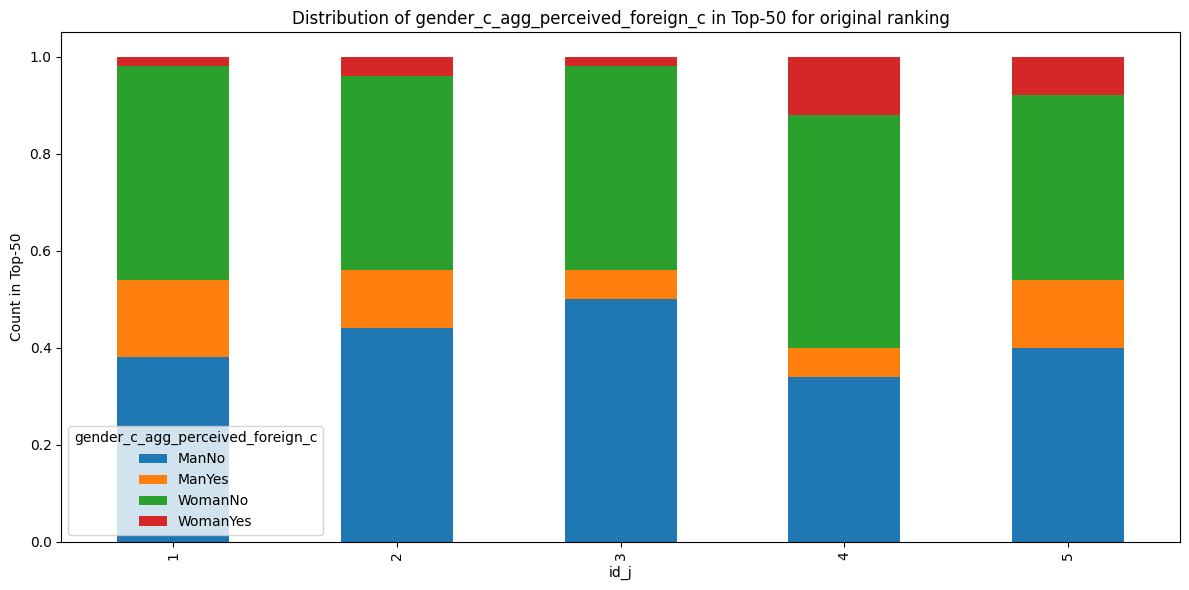

In [244]:
# original ranking
plot_dist_top_k(ranking_original, query_col_data, sensitive_col=intersectional_col_data, k=50, model="original")

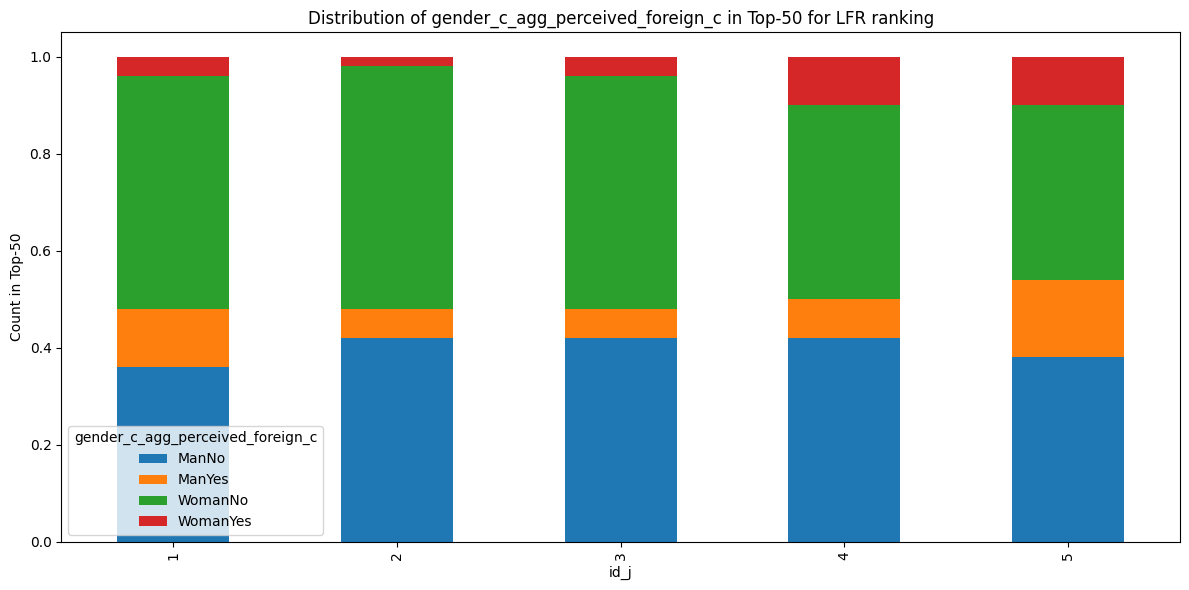

In [245]:
# lfr model
plot_dist_top_k(ranking_lfr, query_col_data, sensitive_col=intersectional_col_data, k=50, model="LFR")

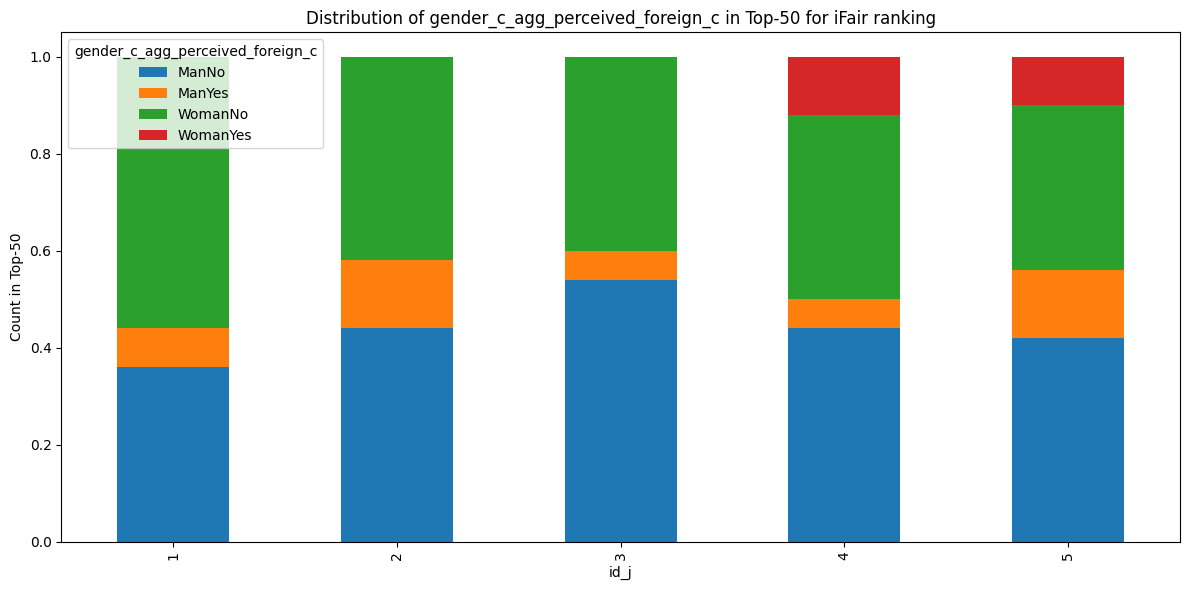

In [246]:
# iFair model
plot_dist_top_k(ranking_ifair, query_col_data, sensitive_col=intersectional_col_data, k=50, model="iFair")

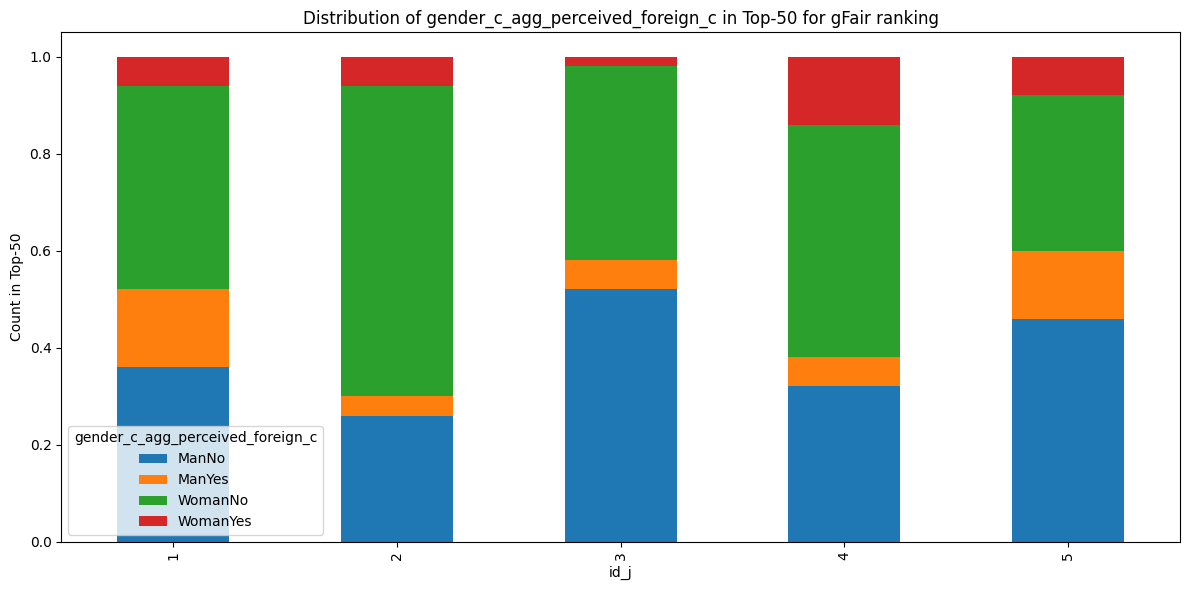

In [247]:
# gFair Model
plot_dist_top_k(ranking_gfair, query_col_data, sensitive_col=intersectional_col_data, k=50, model="gFair")